# 循环神经网络的从零开始实现



In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline
import math
import mindspore
import numpy as np
import mindspore.numpy as mnp
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import Tensor
from d2l import mindspore as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

独热编码

In [3]:
ops.OneHot()(Tensor([0, 2], mindspore.int32), len(vocab), Tensor(1.0, mindspore.float32), Tensor(0.0, mindspore.float32))

Tensor(shape=[2, 28], dtype=Float32, value=
[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00 ...  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00 ...  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

小批量数据形状是（批量大小,时间步数）

In [4]:
X = mnp.arange(10).reshape((2, 5))
ops.OneHot()(X.T, 28, Tensor(1.0, mindspore.float32), Tensor(0.0, mindspore.float32)).shape

(5, 2, 28)

初始化循环神经网络模型的模型参数

In [5]:
from mindspore import Tensor, Parameter, ParameterTuple

def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size
    W_xh = Parameter(Tensor(np.random.randn(num_inputs, num_hiddens) * 0.01, mindspore.float32))
    W_hh = Parameter(Tensor(np.random.randn(num_hiddens, num_hiddens) * 0.01, mindspore.float32))
    b_h = Parameter(Tensor(np.zeros(num_hiddens), mindspore.float32))
    W_hq = Parameter(Tensor(np.random.randn(num_hiddens, num_outputs) * 0.01, mindspore.float32))
    b_q = Parameter(Tensor(np.zeros(num_outputs), mindspore.float32))
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    
    return ParameterTuple(params)

一个`init_rnn_state`函数在初始化时返回隐状态

In [6]:
def init_rnn_state(batch_size, num_hiddens):
    return (Tensor(np.zeros((batch_size, num_hiddens))),)

下面的`rnn`函数定义了如何在一个时间步内计算隐状态和输出

In [7]:
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for i in range(inputs.shape[0]):
        X = inputs[i]
        H = ops.Tanh()(ops.matmul(X, W_xh) + ops.matmul(H, W_hh) + b_h)
        Y = ops.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return ops.Concat(axis=0)(outputs), (H, )

创建一个类来包装这些函数

In [8]:
class RNNModelScratch(nn.Cell): 
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens,
                 get_params, init_state, forward_fn):
        super().__init__()
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens)
        self.init_state, self.forward_fn = init_state, forward_fn
        self.on_value = Tensor(1.0, mindspore.float32)
        self.off_value = Tensor(0.0, mindspore.float32)
        
    def construct(self, X, state):
        X = ops.OneHot()(X.T, self.vocab_size, self.on_value, self.off_value)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

检查输出是否具有正确的形状

In [9]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, 
                      get_params, init_rnn_state, rnn)
state = init_rnn_state(X.shape[0], num_hiddens)
Y, new_state = net(X, state)
Y.shape, len(new_state), new_state[0].shape

((10, 28), 1, (2, 512))

首先定义预测函数来生成`prefix`之后的新字符

In [10]:
def predict_ch8(prefix, num_preds, net, vocab):  
    """在`prefix`后面生成新字符。"""
    state = init_rnn_state(batch_size=1, num_hiddens=num_hiddens)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: mindspore.Tensor([outputs[-1]], mindspore.int32).reshape((1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(axis=1).reshape(1).asnumpy()))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 10, net, vocab)

'time traveller czedjadbgh'

梯度裁剪
$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$$

In [11]:
def grad_clipping(grads, theta):  
    """裁剪梯度。"""
    return ops.clip_by_global_norm(grads, theta)

In [12]:
class TrainCh8(nn.Cell):
    def __init__(self, network, optimizer, theta):
        super().__init__()
        self.network = network
        self.optimizer = optimizer
        self.grad = ops.GradOperation(get_by_list=True)
        self.theta = theta

    def construct(self, *inputs):
        loss = self.network(*inputs)
        grads = self.grad(self.network, self.optimizer.parameters)(*inputs)
        grads = grad_clipping(grads, self.theta)
        loss = ops.depend(loss, self.optimizer(grads))
        return loss

class NetWithLossCh8(nn.Cell):
    def __init__(self, network, loss):
        super().__init__()
        self.network = network
        self.loss = loss
        
    def construct(self, *inputs):
        y_hat, _ = self.network(*inputs[:-1])
        loss = self.loss(y_hat, inputs[-1])
        return loss

定义一个函数在一个迭代周期内训练模型

In [13]:
def train_epoch_ch8(net, state, train_iter):
    """训练网络一个迭代周期（定义见第8章）。"""
    timer = d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        y = Y.T.reshape(-1)
        l = net(X, state, y)
        metric.add(l.asnumpy() * y.size, y.size)
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

循环神经网络模型的训练函数既支持从零开始实现，也可以使用高级API来实现

In [14]:
def train_ch8(net, train_iter, vocab, lr, num_epochs):
    """训练模型（定义见第8章）。"""
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    optim = nn.SGD(net.trainable_params(), lr)
    net_with_loss = NetWithLossCh8(net, loss)
    train = TrainCh8(net_with_loss, optim, 1)
    
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab)
    
    state = net.begin_state(train_iter.batch_size)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            train, state, train_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒')
    print(predict('time traveller'))
    print(predict('traveller'))

现在，我们训练循环神经网络模型

困惑度 1.5, 67235.2 词元/秒
time travellerit s against reason said the time travellerit s ag
travellerit s against reason said filby he trins an thetint


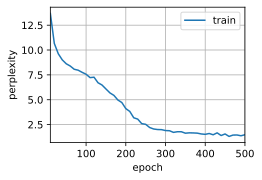

In [15]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs)